# Chapter 4: Influential Classification Tools - ResNet from Scratch

In this notebook, we will cover one of the state-of-the-art classifiers presented in Chapter 4: **_ResNet_**. Reimplementing this CNN is a great exercise to demonstrate how far we have gone so far, coding in a modular way a performant network from 18 to 152 layer deep!

We will train and test our implementation on Tiny-ImageNet, reusing the input pipeline defined in the first notebook for Chapter 4.

In [18]:
import tensorflow as tf
import os

In [19]:
from tiny_imagenet import (
    tiny_imagenet, _training_augmentation_fn, 
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES)

TINY_IMAGENET_ROOT_FOLDER = os.path.expanduser('~/datasets/tiny-imagenet-200/')

NUM_TRAINING_IMAGES = 500 * NUM_CLASSES
NUM_VAL_IMAGES = 50 * NUM_CLASSES
batch_size = 32
num_epochs = 300


## ResNet Implementation with Keras

Once again, we will opt for the Keras API to speed up the implementation. By the end of this section, we will have a _ResNet-builder_ tool, able to instantiate any of the usual residual networks (ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-102, etc.)!

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Activation, Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, add)
import tensorflow.keras.regularizers as regulizers

### Implementing the Residual Blocks

In order to implement such a model-builder function, able to generate networks of various sizes, we need to make the ResNet implementation modular. Therefore, we will implement the ResNet main components, the residual blocks, in a modular way, so that we can chain them indefinitely.

In Chapter 4, we saw that the residual blocks are composed of:
 - one _residual_ branch, applying a 3x3 convolution to the input, followed by batch normalization and ReLu activation;
 - one _shortcut_ branch, directly forwarding the input without modification, or only applying a 1x1 convolution to adapt the input volume in case it changed in the other branch;
 - one _merge_ operation, performing an element-wise addition between the results of the two branches.

We will now implement each of this sub-modules. First, let us wrap the `conv-batnchnorm-relu` stack of layers into a single function we could reuse at will:

In [21]:
def _res_conv(filters, kernel_size=3, padding='same', strides=1, use_relu=True, use_bias=False, name='cbr',
              kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    """
    Return a layer block chaining conv, batchnrom and reLU activation.
    :param filters:                 Number of filters.
    :param kernel_size:             Kernel size.
    :param padding:                 Convolution padding.
    :param strides:                 Convolution strides.
    :param use_relu:                Flag to apply ReLu activation at the end.
    :param use_bias:                Flag to use bias or not in Conv layer.
    :param name:                    Name suffix for the layers.
    :param kernel_initializer:      Kernel initialisation method name.
    :param kernel_regularizer:      Kernel regularizer.
    :return:                        Callable layer block
    """

    def layer_fn(x):
        conv = Conv2D(
            filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, 
            name=name + '_c')(x)
        res = BatchNormalization(axis=-1, name=name + '_bn')(conv)
        if use_relu:
            res = Activation("relu", name=name + '_r')(res)
        return res

    return layer_fn

Thanks to this function, we can add this stack of 3 layers to our network simply with `x = _conv_batchnorm_relu(**params)(x)`. We are therefore almost done covering the implementation of the 1st branch in the residual blocks.

Now we will deal with the _shortcut_ branch. For simplicity, we will wrap its operation along with the following _merge_ operation since. Indeed, thisfunction already needs to receive as parameters both the input tensor and the result of the _residual_ branch to the _shortcut_ one, so that it can compare the tensors' shapes to check if the dimensions were changed. If so, a 1x1  convolution is applied to resize the input tensor accordingly before the _merge_. Otherwise, the input tensor is left untouched. And since the function has both thew _residual_ and the _shortcut_ results, it is a matter of a single line to do the _merge_ right away:

In [22]:
def _merge_with_shortcut(kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4), name='block'):
    """
    Return a layer block which merge an input tensor and the corresponding 
    residual output tensor from another branch.
    :param kernel_initializer:      Kernel initialisation method name.
    :param kernel_regularizer:      Kernel regularizer.
    :param name:                    Name suffix for the layers.
    :return:                        Callable layer block
    """

    def layer_fn(x, x_residual):
        # We check if `x_residual` was scaled down. If so, we scale `x` accordingly with a 1x1 conv:
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2]))  # horizontal stride
            )
            x_residual_channels = x_residual_shape[3]
            shortcut = Conv2D(filters=x_residual_channels, kernel_size=(1, 1), padding="valid", strides=strides,
                              kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
                              name=name + '_shortcut_c')(x)

        merge = add([shortcut, x_residual])
        return merge

    return layer_fn

We now have everything to create complete residual blocks:

In [23]:
def _residual_block_basic(filters, kernel_size=3, strides=1, use_bias=False, name='res_basic',
                          kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    """
    Return a basic residual layer block.
    """

    def layer_fn(x):
        x_conv1 = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=strides, 
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr_1')(x)
        x_residual = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=strides, 
            use_relu=False, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr_2')(x_conv1)
        merge = _merge_with_shortcut(kernel_initializer, kernel_regularizer,name=name)(x, x_residual)
        merge = Activation('relu')(merge)
        return merge

    return layer_fn

With this implementation, we can easily chain residual blocks, e.g.:
    # x = previous layer
    x = _residual_block_basic(filters=64, strides=2)(x)
    x = _residual_block_basic(filters=64, strides=1)(x)
    # ...
    
Before building our complete model, we will however implement a different type of residual blocks. Indeed, this basic block becomes quite costly in terms of parameters and computations the deeper the networks goes. In their paper introducing ResNets, He et al. proposed a second type of blocks to replace the basic ones for deeper architectures. To keep in check the number of parameters, those blocks make use of the _bottleneck_ technique we presented with the Inception models. The 3x3 convolution is simply surrounded by 1x1 ones as follow:

In [24]:
def _residual_block_bottleneck(filters, kernel_size=3, strides=1, use_bias=False, name='res_bottleneck',
                               kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    """
    Return a residual layer block with bottleneck, recommended for deep ResNets (depth > 34).
    """

    def layer_fn(x):
        x_bottleneck = _res_conv(
            filters=filters, kernel_size=1, padding='valid', strides=strides, 
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr1')(x)
        x_conv = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=1, 
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr2')(x_bottleneck)
        x_residual = _res_conv(
            filters=filters * 4, kernel_size=1, padding='valid', strides=1, 
            use_relu=False, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
            name=name + '_cbr3')(x_conv)
        merge = _merge_with_shortcut(kernel_initializer, kernel_regularizer, name=name)(x, x_residual)
        merge = Activation('relu')(merge)
        return merge

    return layer_fn

### Chaining Blocks into Modular Networks

In Chapter 4, we saw that residual blocks in usual ResNet models are chained according to a specific pattern (c.f. figure presenting the ResNet architecture). Every `b` blocks, we find a residual block with `strides = 2` reducing the spatial dimensionality (followed by `b - 1` blocks with `strides = 1`). It will make the rest of the implementation much easier if we wrap the instantiation of these `b` blocks together:

In [25]:
def _residual_macroblock(block_fn, filters, repetitions=3, kernel_size=3, strides_1st_block=1, use_bias=False,
                         kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4),
                         name='res_macroblock'):
    """
    Return a layer block, composed of a repetition of `N` residual blocks.
    :param block_fn:                Block layer method to be used.
    :param repetitions:             Number of times the block should be repeated inside.
    :param filters:                 Number of filters.
    :param kernel_size:             Kernel size.
    :param strides_1st_block:       Convolution strides for the 1st block.
    :param use_bias:                Flag to use bias or not in Conv layer.
    :param kernel_initializer:      Kernel initialisation method name.
    :param kernel_regularizer:      Kernel regularizer.
    :return:                        Callable layer block
    """

    def layer_fn(x):
        for i in range(repetitions):
            block_name = "{}_{}".format(name, i) 
            strides = strides_1st_block if i == 0 else 1
            x = block_fn(filters=filters, kernel_size=kernel_size, 
                         strides=strides, use_bias=use_bias,
                         kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
                         name=block_name)(x)
        return x

    return layer_fn

As before, the function we just wrote makes it possible to easily chain these macro-blocks together into a network as deep as we wish! It is now just a matter of adding the 3 layers preceeding the residual blocks (a 7x7 convolution and a max-pooling) as well as the final layers leading to the predictions (avg-pooling and FC):

In [26]:
def ResNet(input_shape, num_classes=1000, block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
           use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regulizers.l2(1e-4)):
    """
    Build a ResNet model for classification.
    :param input_shape:             Input shape (e.g. (224, 224, 3))
    :param num_classes:             Number of classes to predict
    :param block_fn:                Block layer method to be used.
    :param repetitions:             List of repetitions for each macro-blocks the network should contain.
    :param use_bias:                Flag to use bias or not in Conv layer.
    :param kernel_initializer:      Kernel initialisation method name.
    :param kernel_regularizer:      Kernel regularizer.
    :return:                        ResNet model.
    """

    # Input and 1st layers:
    inputs = Input(shape=input_shape)
    conv = _res_conv(filters=64, kernel_size=7, strides=2, use_relu=True, use_bias=use_bias,
                     kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(inputs)
    maxpool = MaxPooling2D(pool_size=3, strides=2, padding='same')(conv)

    # Chain of residual blocks:
    filters = 64
    strides = 2
    res_block = maxpool
    for i, repet in enumerate(repetitions):
        # We do not further reduce the input size for the 1st block (max-pool applied just before):
        block_strides = strides if i != 0 else 1
        macroblock_name = "block_{}".format(i) 
        res_block = _residual_macroblock(
            block_fn=block_fn, repetitions=repet, name=macroblock_name,
            filters=filters, strides_1st_block=block_strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(res_block)
        filters = min(filters * 2, 1024) # we limit to 1024 filters max

    # Final layers for prediction:
    res_spatial_dim = tf.keras.backend.int_shape(res_block)[1:3]
    avg_pool = AveragePooling2D(pool_size=res_spatial_dim, strides=1)(res_block)
    flatten = Flatten()(avg_pool)
    predictions = Dense(units=num_classes, kernel_initializer=kernel_initializer, activation='softmax')(flatten)

    # Model:
    model = Model(inputs=inputs, outputs=predictions)
    return model

We have our ResNet-builder function! Playing with the `repetitions` parameter, we can now spawn networks as deep as we want.

With this, we can easily define the classic ResNet models:

In [27]:
def ResNet18(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet34(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_basic, repetitions=(3, 4, 6, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet50(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    # Note: ResNet50 is similar to ResNet34,
    # with the basic blocks replaced by bottleneck ones (3 conv layers each instead of 2)
    return ResNet(input_shape, num_classes, block_fn=_residual_block_bottleneck, repetitions=(3, 4, 6, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet101(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_bottleneck, repetitions=(3, 4, 23, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)


def ResNet152(input_shape, num_classes=1000, use_bias=True,
             kernel_initializer='he_normal', kernel_regularizer=None):
    return ResNet(input_shape, num_classes, block_fn=_residual_block_bottleneck, repetitions=(3, 8, 36, 3),
                  use_bias=use_bias, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)

### Demonstrating with ResNet-50

For the rest of this notebook, we will opt for ResNet-50. 

Note that for their ImageNet experiments, the ResNet authors used 224x224 images as input. In order to have a similar network, we will consider the same input dimensions (adding a proper scaling operation to our input pipeline, to resize the Tiny-ImageNet samples from 64x64 to 224x224):

In [28]:
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [29]:
resnet50 = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES)
resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
cbr_c (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
cbr_bn (BatchNormalization)     (None, 112, 112, 64) 256         cbr_c[0][0]                      
__________________________________________________________________________________________________
cbr_r (Activation)              (None, 112, 112, 64) 0           cbr_bn[0][0]                     
__________________________________________________________________________________________________
max_poolin

## ResNet Usage

We will now apply our ResNet-50 model to the classification of the Tiny-ImageNet pictures.

### Preparing the Data

For the input pipelines, we simply reuse the functions we implemented in the previous [notebook](./ch4_notebook_1_data_preparation.ipynb):

In [30]:
train_images, train_labels, class_ids, class_readable_labels = tiny_imagenet(
    phase='train', shuffle=True, batch_size=batch_size, num_epochs=num_epochs, wrap_for_estimator=False,
    augmentation_fn=_training_augmentation_fn, root_folder=TINY_IMAGENET_ROOT_FOLDER,
    resize_to=[IMG_HEIGHT, IMG_WIDTH])

val_images, val_labels, _, _ = tiny_imagenet(
    phase='val', shuffle=False, batch_size=batch_size, num_epochs=None, wrap_for_estimator=False,
    augmentation_fn=None, root_folder=TINY_IMAGENET_ROOT_FOLDER,
    resize_to=[IMG_HEIGHT, IMG_WIDTH])

Note that `tiny_imagenet()` has been edited compare to the previous implementation, to add the `resize_to` parameter (to obtain 224x224 images).

Note also that TensorFlow objects from the `tf.data` API (datasets, iterators) are indeed compatible with Keras methods such as `model.fit(...)`. However, to work properly together, we need to specify to Keras how many batches per epoch such Dataset objects have (when calling `model.fit(...)`, with the parameter `steps_per_epoch` for the number of training batches, and `validation_steps` for the validation ones).

In [31]:
train_steps_per_epoch = NUM_TRAINING_IMAGES // batch_size
val_steps_per_epoch = NUM_VAL_IMAGES // batch_size

### Training the Network


As we saw in previous chapters and notebooks, training a model with Keras is straightforward. We first instantiate the optimizer, as well as some callbacks to visualize results or regularly save the trained model:


In [32]:
optimizer = tf.keras.optimizers.Adam() #tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

model_dir = './models/resnet_from_scratch'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_sparse_categorical_accuracy'),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model (e.g., every 5 epochs), specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5)
]


To imitate the ImageNet experiments, we will add the top-5 accuracy metrics we presented in the chapter.

Conveniently, Keras already provides `tf.keras.metrics.top_k_categorical_accuracy` and `tf.keras.metrics.sparse_top_k_categorical_accuracy` which both implement top-k accuracy (the former should be used if the labels are already one-hot, whereas metrics/losses with "`sparse_`" for prefix can and should be used if labels have not been converted - Keras then take care of the one-hot operation itself).
For our top-5 accuracy, we thus reuse the function provided by Keras to generate a custom metrics with `k=5`. Note that custom metrics should have for signature `(true_labels, predicted_labels)` and have an attribute `__name__` for display:

In [33]:
import functools

sparse_top_5_categorical_accuracy = functools.partial(
    tf.keras.metrics.sparse_top_k_categorical_accuracy, k=5)
sparse_top_5_categorical_accuracy.__name__ = 'sparse_top_5_categorical_accuracy'

We can now compile our model with a classification loss and the desired metrics, before launching the training:

In [34]:
resnet50.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                 metrics=['sparse_categorical_accuracy', sparse_top_5_categorical_accuracy])

history = resnet50.fit(train_images, train_labels,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
                       validation_data=(val_images, val_labels), validation_steps=val_steps_per_epoch,
                       verbose=1, callbacks=callbacks)

Epoch 1/300
3125/3125 [==============================] - 753s 241ms/step - loss: 5.6293 - sparse_categorical_accuracy: 0.0091 - sparse_top_5_categorical_accuracy: 0.0492 - val_loss: 5.3055 - val_sparse_categorical_accuracy: 0.0067 - val_sparse_top_5_categorical_accuracy: 0.0312
Epoch 2/300
3125/3125 [==============================] - 742s 238ms/step - loss: 4.9632 - sparse_categorical_accuracy: 0.0211 - sparse_top_5_categorical_accuracy: 0.0877 - val_loss: 5.1963 - val_sparse_categorical_accuracy: 0.0191 - val_sparse_top_5_categorical_accuracy: 0.0806
Epoch 3/300
3125/3125 [==============================] - 743s 238ms/step - loss: 4.5916 - sparse_categorical_accuracy: 0.0511 - sparse_top_5_categorical_accuracy: 0.1764 - val_loss: 4.8690 - val_sparse_categorical_accuracy: 0.0418 - val_sparse_top_5_categorical_accuracy: 0.1481
Epoch 4/300
3125/3125 [==============================] - 741s 237ms/step - loss: 4.1257 - sparse_categorical_accuracy: 0.1056 - sparse_top_5_categorical_accuracy: 

We can either follow the training thanks to Keras' console logs, or in Tensorboard thanks to the callback we set up (Tensoboard can be launched with `tensorboard --logdir ./models`, and then accessed at [localhost:6006](localhost:6006)). 

Training a CNN from scratch is a long, expensive operation, as we can observe here (which is one of the reasons to apply transfer learning whenever it is possible, as we will demonstrate in the next notebooks). 

Note that the `history` object returned by `model.fit()` can also be used to plot some of the training metrics:

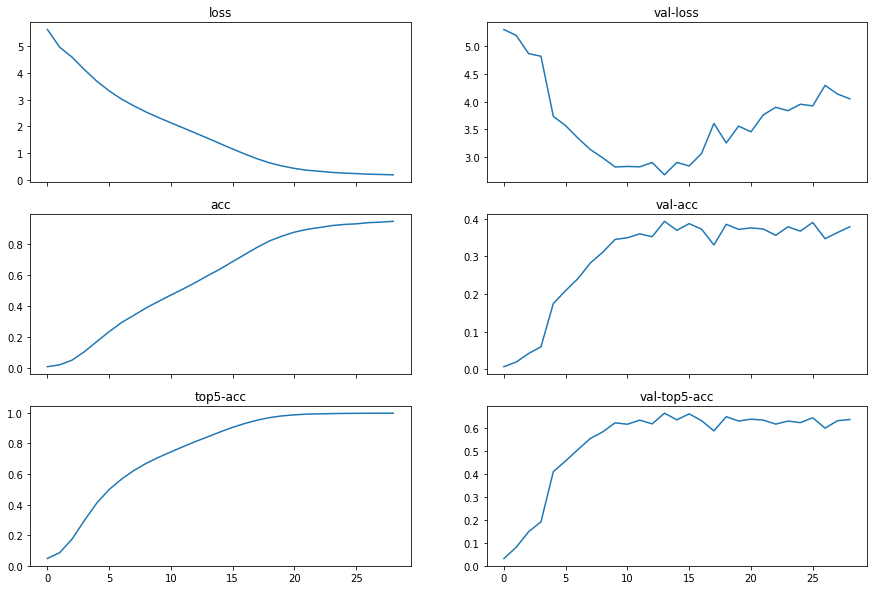

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['sparse_categorical_accuracy'])
ax[1, 1].plot(history.history['val_sparse_categorical_accuracy'])
ax[2, 0].plot(history.history['sparse_top_5_categorical_accuracy'])
ax[2, 1].plot(history.history['val_sparse_top_5_categorical_accuracy'])


In [38]:
best_val_acc = max(history.history['val_sparse_categorical_accuracy']) * 100
best_val_top5 = max(history.history['val_sparse_top_5_categorical_accuracy']) * 100

print('Best val acc:  {:2.2f}%'.format(best_val_acc))
print('Best val top5: {:2.2f}%'.format(best_val_top5))


Best val acc:  39.32%
Best val top5: 66.52%


Guessing the exact correct class out of 200 almost 40% of the time is not a bad start. We should keep in mind that Tiny-ImageNet is a difficult dataset, with not that many training samples per class. Inspired by the notions covered in the book, we will demonstrate in the next notebooks how to increase the accuracy nonetheless.

### Predicting with the Network

Since we know have a complex model, fully implemented and trainedby ourselves, we cannot conclude this notebook without at least testing it once on unseen images.

For that purpose, we first implement some utility functions to load the test images (simply as Numpy arrays), to get the top-5 predictions and corresponing labels from the model's outputs, and finally to plot the results:

In [55]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def load_image(image_path, size):
    """
    Load an image as a Numpy array.
    :param image_path:  Path of the image
    :param size:        Target size
    :return             Image array, normalized between 0 and 1
    """
    return img_to_array(load_img(image_path, target_size=size)) / 255.


def process_predictions(class_probabilities, class_ids, class_readable_labels, k=5):
    """
    Process a batch of predictions from our estimator.
    :param class_probabilities:     Prediction results returned by the Keras classifier for a batch of data
    :param class_ids:               Class IDs to recover predicted labels
    :param class_readable_labels:   Dictionary of readable-class labels, for display
    :param k:                       Number of top predictions to consider
    :return                         Readable labels and probabilities for the predicted classes
    """
    
    topk_labels, topk_probabilities = [], []
    for i in range(len(class_probabilities)):
        # Getting the top-k predictions:
        topk_classes = sorted(np.argpartition(class_probabilities[i], -k)[-k:])
    
        # Getting the corresponding labels and probabilities:
        topk_labels.append([class_readable_labels[class_ids[predicted]] for predicted in topk_classes])
        topk_probabilities.append(class_probabilities[i][topk_classes])
    
    return topk_labels, topk_probabilities


def display_predictions(images, topk_labels, topk_probabilities):
    """
    Plot a batch of predictions.
    :param images:                  Batch of input images
    :param topk_labels:             String labels of predicted classes
    :param topk_probabilities:      Probabilities for each class
    """
    num_images = len(images)
    num_images_sqrt = np.sqrt(num_images)
    plot_cols = plot_rows = int(np.ceil(num_images_sqrt))
    
    figure = plt.figure(figsize=(13,10))
    grid_spec = gridspec.GridSpec(plot_cols, plot_rows)
    
    for i in range(num_images):
        img, pred_labels, pred_proba = images[i], topk_labels[i], topk_probabilities[i]
        # Shortening the labels to better fit in the plot:
        pred_labels = [label.split(',')[0][:20] for label in pred_labels]
        
        grid_spec_i = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[i], hspace=0)
        
        # Drawing the input image:
        ax_img = figure.add_subplot(grid_spec_i[0])
        ax_img.imshow(img)
        
        # Plotting a bar chart for the predictions:
        ax_pred = figure.add_subplot(grid_spec_i[1])
        y_pos = np.arange(len(pred_labels))
        ax_pred.barh(y_pos, pred_proba, align='center')
        ax_pred.set_yticks(y_pos)
        ax_pred.set_yticklabels(pred_labels)
        ax_pred.invert_yaxis()
        
    plt.tight_layout()
    plt.show()

We now load the unlabeled test images of Tiny-ImageNet:

In [56]:
test_filenames = glob.glob(os.path.join(TINY_IMAGENET_ROOT_FOLDER, 'test', 'images', '*'))
test_images = np.asarray([load_image(file, size=(IMG_HEIGHT, IMG_WIDTH)) for file in test_filenames])
print('Test Images: {}'.format(test_images.shape))

Test Images: (10000, 224, 224, 3)


Finally, we can use our model to predict image per image or batch per batch, and we can use the utility functions we just implemented to display the results:

Predicted class probabilities: (16, 200)


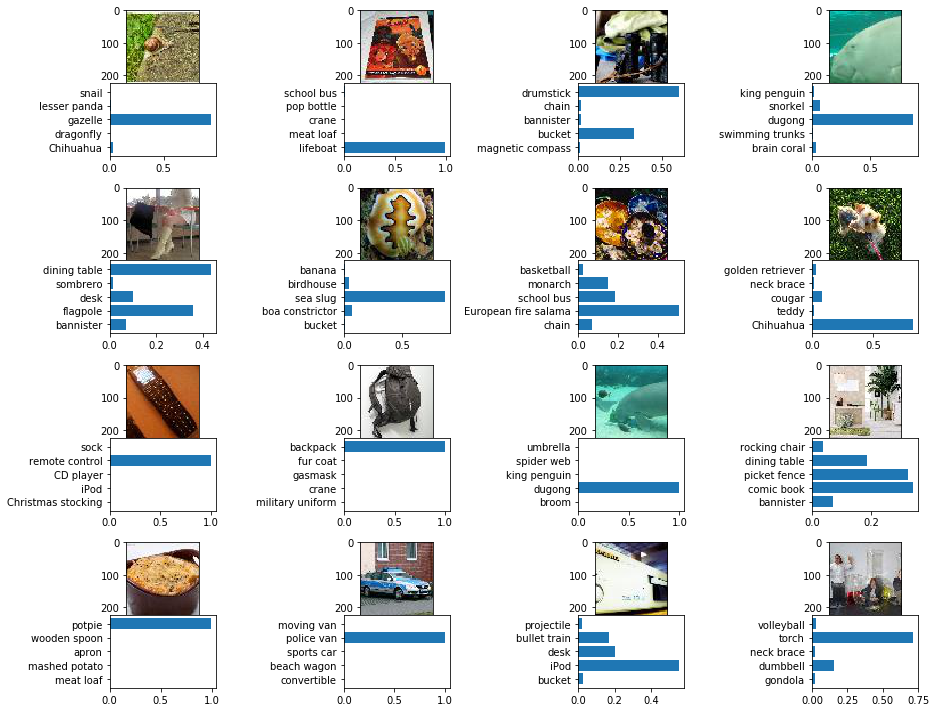

In [57]:
image_batch = test_images[:16]
predictions = resnet50.predict_on_batch(image_batch)
print('Predicted class probabilities: {}'.format(predictions.shape))

top5_labels, top5_probabilities = process_predictions(predictions, class_ids, class_readable_labels)
    
display_predictions(image_batch, top5_labels, top5_probabilities)

We covered quite some ground with this notebook! Applying the knowledge acquired from the book, we re-implemented a complete state-of-the-art CNN and applied it to a difficult dataset. We monitored its training and learned how to visualize classification predictions.
These skills will be further honed in the remaining notebooks covering Chapter 4.